In [2]:
import argparse
import json
import logging
import os
import random
import re
import warnings

import torch
from torch import nn
from tqdm import tqdm
from transformers import PreTrainedTokenizer, AutoModelForCausalLM, AutoTokenizer

import linear_rep_geometry as lrg

from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np

/home/itai/research/linear_rep_geometry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
all_concept_vectors = []
inner_product_matrix_path = os.path.join(
    inner_product_matrix_path, "concept_vector.npy"
)
os.makedirs(os.path.dirname(inner_product_matrix_path), exist_ok=True)
np.save(
    inner_product_matrix_path,
    [concept_vector.cpu().numpy() for concept_vector in all_concept_vectors],
)

In [3]:
PROMPT_TEMPLATES = {
    "reflection": "Consider the deeper meaning behind this: {}\nThis text reflects values related to:",
    "analysis": "Analyzing the underlying principles in: {}\nThe core values expressed here are:",
    "implicit": "Looking at the implicit meaning of: {}\nThe fundamental values shown are:",
    "explicit": "What values are represented in this text: {}\nThe text demonstrates values of:",
    "bare": "{}",
    "theme": "What is the main theme in this text: {}\nKey themes include:",
    "topic": "Identify the primary topics discussed in: {}\nMain topics covered are:",
}

In [4]:
model_path = "meta-llama/Llama-3.2-3B-Instruct"  # [meta-llama/Llama-3.1-8B-Instruct, meta-llama/Llama-2-7b-hf, meta-llama/Llama-3.2-3B-Instruct]
dataset_type = "valuenet"  # [valuenet]
concept_direction = "pos2neg"  # [pos2neg, pos2neutral]
norm_type = "base"  # [base, norm_sentence_structure, norm_topic]
prompt_type = "reflection"  # [bare, reflection, analysis, implicit, explicit]

# Basic config
model_name = model_path.split('/')[1].lower()
num_sample = 1000
save_dir = "tmp_matrices"
counterfactual_output_path = f"/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/{concept_direction}/{norm_type}"
analyzed_figure_path = f"/home/itai/research/linear_rep_geometry/figures/{model_name}/{dataset_type}/{concept_direction}/{norm_type}/{prompt_type}"
generation_random_output_path = f"/home/itai/research/linear_rep_geometry/generated/{model_name}/{dataset_type}/{concept_direction}/{norm_type}/{prompt_type}/random.json"
generation_counterfactual_output_path = f"/home/itai/research/linear_rep_geometry/generated/{model_name}/{dataset_type}/{concept_direction}/{norm_type}/{prompt_type}/counterfactual.json"
random_txt_path = f"/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/random_pairs/{norm_type}/random_1000_pairs.txt"

In [5]:
def get_sequence_pairs(filepath: str, num_samples: int = 1000) -> list[list[str]]:
    with open(filepath, encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]

    if len(lines) > num_samples:
        lines = random.sample(lines, num_samples)
    pairs = [line.split("\t") for line in lines]

    return pairs

def generate_text(
    model: nn.Module,
    tokenizer: PreTrainedTokenizer,
    prompts: list[str],
    prompt_type: str = "bare",
    max_new_tokens: int = 100,
    batch_size: int = 16,
    max_save_step: int = 1000,
) -> list[str]:
    prompt_templates = {
        "reflection": "Consider the deeper meaning behind this: {}\nThis text reflects values related to:",
        "analysis": "Analyzing the underlying principles in: {}\nThe core values expressed here are:",
        "implicit": "Looking at the implicit meaning of: {}\nThe fundamental values shown are:",
        "explicit": "What values are represented in this text: {}\nThe text demonstrates values of:",
        "bare": "{}",
        "theme": "What is the main theme in this text: {}\nKey themes include:",
        "topic": "Identify the primary topics discussed in: {}\nMain topics covered are:",
    }

    if prompt_type not in prompt_templates:
        raise ValueError(
            f"Invalid prompt_type: {prompt_type}. Available types: {list(prompt_templates.keys())}"
        )

    template = prompt_templates[prompt_type]
    formatted_prompts = [template.format(prompt) for prompt in prompts]

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    tokenizer.padding_side = "left"
    generated_texts = []

    # max_save_stepをバッチサイズで考慮
    effective_max_save_step = max_save_step // batch_size * batch_size

    for i in tqdm(
        range(0, len(formatted_prompts), batch_size),
        desc="Generating texts",
        total=len(formatted_prompts) // batch_size
        + bool(len(formatted_prompts) % batch_size),
    ):
        if i > effective_max_save_step:
            break
        batch_prompts = formatted_prompts[i : i + batch_size]
        inputs = tokenizer(
            batch_prompts, return_tensors="pt", padding=True, truncation=True
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1,
                pad_token_id=tokenizer.pad_token_id,
                do_sample=True,
                temperature=0.7,
            )

        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_inputs = tokenizer.batch_decode(
            inputs.input_ids, skip_special_tokens=True
        )

        batch_generated = [
            output[len(input_text) :].strip()
            for output, input_text in zip(decoded_outputs, decoded_inputs, strict=False)
        ]
        generated_texts.extend(batch_generated)

    return generated_texts

def save_generation_results(
    pairs: list[list[str]],
    model: nn.Module,
    tokenizer: PreTrainedTokenizer,
    output_path: str,
    concept_name: str,
    prompt_type: str,
    max_new_tokens: int = 100,
    batch_size: int = 8,
    max_save_step: int = 1000,
) -> None:
    concept_texts = [pair[0] for pair in pairs]
    non_concept_texts = [pair[1] for pair in pairs]

    generated_concept_texts = generate_text(
        model,
        tokenizer,
        concept_texts,
        prompt_type,
        max_new_tokens,
        batch_size,
        max_save_step,
    )
    generated_non_concept_texts = generate_text(
        model,
        tokenizer,
        non_concept_texts,
        prompt_type,
        max_new_tokens,
        batch_size,
        max_save_step,
    )

    results = [
        {
            "concept_text": c_text,
            "non_concept_text": nc_text,
            "generated_text_concept": gc_text,
            "generated_text_non_concept": gnc_text,
        }
        for c_text, nc_text, gc_text, gnc_text in zip(
            concept_texts,
            non_concept_texts,
            generated_concept_texts,
            generated_non_concept_texts,
            strict=False,
        )
    ]

    output_path = output_path.split(".json")[0] + f"_{concept_name}.json"
    print(f"{output_path=}")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

In [6]:
def get_hidden_layer_n(model, tokenizer, sequences: list[str], n_layer: int, batch_size:int =4, embedding_strategy: str="last"):
    """
    n_layer層目のの隠れ層の行列を取得する
    Returns:
        embeddings: shape=(len(sequences), hidden_size)
    """
    total_batches = (len(sequences) + batch_size - 1) // batch_size
    pbar = tqdm(
        range(0, len(sequences), batch_size),
        total=total_batches,
        desc="Processing embeddings",
        unit="batch",
    )
    all_embeddings = []
    for i in pbar:
        batch_texts = sequences[i : i + batch_size]

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
            max_length=128,
        )

        device = next(model.parameters()).device
        input_ids = encoded.input_ids.to(device)
        attention_mask = encoded.attention_mask.to(device)
        if embedding_strategy == "mean":
            with torch.no_grad():
                outputs = model(
                    input_ids, attention_mask=attention_mask, output_hidden_states=True
                )
                hidden_states = outputs.hidden_states
                layer_embeddings = hidden_states[n_layer] # shape: (batch_size, seq_len, hidden_size)
                masked_hidden_state = layer_embeddings * attention_mask.unsqueeze(-1)
                sum_hidden_state = masked_hidden_state.sum(dim=1)
                count_tokens = attention_mask.sum(dim=1).unsqueeze(-1)
                batch_embeddings = sum_hidden_state / count_tokens

                all_embeddings.append(batch_embeddings.cpu())

                del outputs, hidden_states, layer_embeddings, masked_hidden_state, sum_hidden_state
        elif embedding_strategy == "last":
            with torch.no_grad():
                outputs = model(
                    input_ids, attention_mask=attention_mask, output_hidden_states=True
                )
                hidden_states = outputs.hidden_states
                layer_embeddings = hidden_states[n_layer]
                last_hidden_state = layer_embeddings
                last_token_indices = attention_mask.sum(dim=1) - 1
                batch_embeddings = last_hidden_state[
                    torch.arange(last_hidden_state.size(0)), last_token_indices
                ]
                all_embeddings.append(batch_embeddings.cpu())
                del outputs, hidden_states, layer_embeddings, last_hidden_state
        else:
            raise ValueError(f"Invalid embedding_strategy: {embedding_strategy}. Available types: [mean, last]")
    return torch.cat(all_embeddings, dim=0)

In [7]:
def get_counterfactual_pairs(filename: str, prompt_type: str, num_sample: int=1000):
    """
    counterfactual pairが格納されたtxtファイルを読み込み、prompt_typeに従ってpromptを生成する
    Returns:
        base_sequences: list[str]
        target_sequences: list[str]
    """
    if prompt_type not in PROMPT_TEMPLATES:
        raise ValueError(
            f"Invalid prompt_type: {prompt_type}. Available types: {list(PROMPT_TEMPLATES.keys())}"
        )
    prompt_template = PROMPT_TEMPLATES[prompt_type]

    # counterfactual pairが格納されたtxtファイルを読み込む
    with open(filename) as f:
        lines = f.readlines()

    if len(lines) > num_sample:
        lines = random.sample(lines, num_sample)

    text_pairs = []
    for line in lines:
        if line.strip():
            base, target = line.strip().split("\t")
            prefixed_base = prompt_template.format(base) if prompt_template else base
            prefixed_target = prompt_template.format(target) if prompt_template else target
            text_pairs.append((prefixed_base, prefixed_target))

    base_sequences = []
    target_sequences = []

    for base, target in text_pairs:
        base_sequences.append(base)
        target_sequences.append(target)

    return base_sequences, target_sequences

In [8]:
def compute_inner_product_LOO(diff_embeddings, verbose=False):
    """
    Args:
        diff_embeddings: counterfactual pairの差分のembedding (shape: (num_sample, hidden_size))
    Returns:
        inner_product_LOO: Leave-One-Outで計算した内積 (shape: (num_sample, ))
    """
    products = []
    for i in range(diff_embeddings.shape[0]):
        mask = torch.ones(diff_embeddings.shape[0], dtype=torch.bool, device=diff_embeddings.device)
        mask[i] = False
        loo_diff_embeddings = diff_embeddings[mask]
        mean_loo_diff_embeddings = torch.mean(loo_diff_embeddings, dim=0)  # 対象以外の平均 (概念方向)
        loo_mean = mean_loo_diff_embeddings / torch.norm(mean_loo_diff_embeddings)  # 正規化
        product = loo_mean @ diff_embeddings[i]  # 対象の表現と概念方向の内積
        products.append(product)
        if verbose:
            print(f"{loo_diff_embeddings.shape=}")
            print(f"{mean_loo_diff_embeddings.shape=}")
            print(f"{loo_mean.shape=}")
    inner_product_LOO = torch.stack(products)
    if verbose:
        print(f"{inner_product_LOO.shape=}")
    return inner_product_LOO


## model, tokenizerの取得

In [9]:
device_id = 0
device = torch.device(f"cuda:{device_id}")
model = AutoModelForCausalLM.from_pretrained(model_path, device_map={"": device})
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


In [10]:
# Basic model config
num_hidden_layers = model.config.num_hidden_layers
unembedding = model.lm_head.weight.detach()
print("\n* === Model config === *")
print(f"{num_hidden_layers=}")
print(f"{unembedding.shape=}")
print("=" * 24)



* === Model config === *
num_hidden_layers=28
unembedding.shape=torch.Size([128256, 3072])


In [11]:
with open("tmp_matrices/filenames.txt") as f:
    filenames = [line.strip() for line in f.readlines()]
with open("tmp_matrices/concept_names.txt") as f:
    concept_names = [line.strip() for line in f.readlines()]

In [12]:
random_pairs = get_sequence_pairs(random_txt_path, int(num_sample))
len(random_pairs)

1000

In [13]:
filename = filenames[0]
base_sequences, target_sequences = (
    get_counterfactual_pairs(
        filename, prompt_type=prompt_type, num_sample=int(num_sample)
    )
)

In [14]:
base_embeddings = get_hidden_layer_n(
    model,
    tokenizer,
    base_sequences,
    n_layer=num_hidden_layers,
    batch_size=4,
    embedding_strategy="last")

target_embeddings = get_hidden_layer_n(
    model,
    tokenizer,
    target_sequences,
    n_layer=num_hidden_layers,
    batch_size=4,
    embedding_strategy="last")

Processing embeddings: 100%|██████████| 250/250 [00:31<00:00,  8.03batch/s]


In [15]:
diff_embeddings = base_embeddings - target_embeddings
diff_embeddings = diff_embeddings / torch.norm(diff_embeddings, dim=1, keepdim=True)
concept_direction_vector = torch.mean(diff_embeddings, dim=0)

print(f"{diff_embeddings.shape=}")
print(f"{concept_direction_vector.shape=}")

diff_embeddings.shape=torch.Size([1000, 3072])
concept_direction_vector.shape=torch.Size([3072])


In [16]:
concept_inner_product_LOO = compute_inner_product_LOO(diff_embeddings)
concept_inner_product_LOO.shape

torch.Size([1000])

In [17]:

random_base_sequences, random_target_sequences = (
    get_counterfactual_pairs(
        random_txt_path, prompt_type=prompt_type, num_sample=int(num_sample)
    )
)
random_base_embeddings = get_hidden_layer_n(
    model,
    tokenizer,
    random_base_sequences,
    n_layer=num_hidden_layers,
    batch_size=4,
    embedding_strategy="last"
)

random_target_embeddings = get_hidden_layer_n(
    model,
    tokenizer,
    random_target_sequences,
    n_layer=num_hidden_layers,
    batch_size=4,
    embedding_strategy="last"
)


Processing embeddings:  65%|██████▍   | 162/250 [00:17<00:09,  9.31batch/s]


KeyboardInterrupt: 

: 

In [68]:
random_diff_embeddings = random_base_embeddings - random_target_embeddings
random_diff_embeddings = random_diff_embeddings / torch.norm(random_diff_embeddings, dim=1, keepdim=True)
random_direction_vector = torch.mean(random_diff_embeddings, dim=0)

print(f"{random_diff_embeddings.shape=}")
print(f"{random_direction_vector.shape=}")

random_diff_embeddings.shape=torch.Size([1000, 3072])
random_direction_vector.shape=torch.Size([3072])


In [70]:
random_inner_product_LOO = compute_inner_product_LOO(random_diff_embeddings)
random_inner_product_LOO.shape

torch.Size([1000])

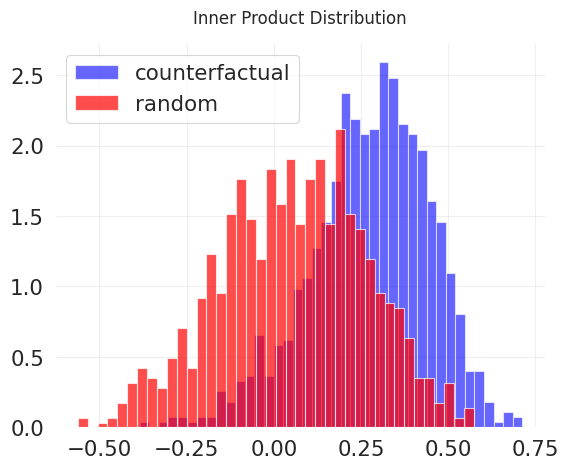

In [90]:
def plot_inner_product_distribution(concept_inner_product_LOO, random_inner_product_LOO):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1, 1, 1)

    ax.hist(concept_inner_product_LOO.cpu().numpy(), bins=40, alpha=0.6, color="blue", label="counterfactual", density=True)
    ax.hist(random_inner_product_LOO.cpu().numpy(), bins=40, alpha=0.7, color="red", label="random", density=True)

    ax.set_title("Inner Product Distribution", fontsize=12, pad=15)
    ax.grid(True, alpha=0.3)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_inner_product_distribution(concept_inner_product_LOO, random_inner_product_LOO)
